# **Abandono de carrera por estudiantes mediante implementación de clasificación con PyTorch**

Asignatura: INF395 - Introducción a las Redes Neuronales y Deep Learning.

Integrantes:
* Bruno Morici - ROL: 202373555-8
* Juan Pablo Fuenzalida - ROL: 202373102-1
* Tutor: Alejandro Veloz


Usando el dataset de la UCL Machine Learning "Students' Dropout and Academic Success Dataset". Acceder mediante el siguiente link : https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## Importación e instalación de librerias necesarias

In [76]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install torch
%pip install tqdm
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo
from tqdm import tqdm

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}') 

Dispositivo utilizado: cpu


## Limpieza y carga del Dataset

In [78]:
# Cargar el dataset (por ID)
dataset = fetch_ucirepo(id=697)

# Acceder a los datos como DataFrame de pandas
df = dataset.data.features
target = dataset.data.targets

# Unirlos si quieres un solo DataFrame
df = pd.concat([df, target], axis=1)

# Mostrar las primeras filas
df.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Información del dataset:**

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

**Revisando si existen valores nulos en el dataset:**

In [80]:
df.isna().sum()

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

**Convertimos los nombres de las columnas a minúsculas para facilitar su manejo:**

In [81]:
df.columns = [col.replace(' ','_').replace("'s",'').replace('\t','').replace('/','_').replace('(','').replace(')','').lower() for col in df.columns]
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime_evening_attendance', 'previous_qualification',
       'previous_qualification_grade', 'nacionality', 'mother_qualification',
       'father_qualification', 'mother_occupation', 'father_occupation',
       'admission_grade', 'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations',
       'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade',
       'curricular_units_2nd_sem_without

Explicación para cada columna de la tabla:

| Columna                                        | Significado                                                                                                                 |
| ---------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| `marital_status`                               | Estado civil del alumno/a al momento de la inscripción.                                                                     |
| `application_mode`                             | Modo de aplicación al curso (por ejemplo, presencial vs. en línea, u otra categoría).                                       |
| `application_order`                            | Orden de la solicitud de ingreso (por ejemplo, cuántas aplicaciones realizó antes, o prioridad de la solicitud).            |
| `course`                                       | Código o identificador del curso al que se inscribió el estudiante.                                                         |
| `daytime_evening_attendance`                   | Asistencia: diurna o vespertina (día vs. noche) para el curso.                                                              |
| `previous_qualification`                       | Tipo de cualificación/título anterior que tenía el estudiante antes de este nivel educativo.                                |
| `previous_qualification_grade`                 | Nota o calificación obtenida en la cualificación anterior.                                                                  |
| `nacionality`                                  | Nacionalidad del estudiante.                                                                                                |
| `mother_qualification`                         | Nivel de formación de la madre del estudiante.                                                                              |
| `father_qualification`                         | Nivel de formación del padre del estudiante.                                                                                |
| `mother_occupation`                            | Ocupación laboral de la madre del estudiante.                                                                               |
| `father_occupation`                            | Ocupación laboral del padre del estudiante.                                                                                 |
| `admission_grade`                              | Nota de admisión al curso/universidad del estudiante.                                                                       |
| `displaced`                                    | Si el estudiante es desplazado (por ejemplo, geográfica o socialmente) o no.                                                |
| `educational_special_needs`                    | Si el estudiante tiene necesidades educativas especiales.                                                                   |
| `debtor`                                       | Si el estudiante adeuda pagos (por ejemplo, matrícula u otros cargos) o no.                                                 |
| `tuition_fees_up_to_date`                      | Si las tasas de matrícula están al día o no.                                                                                |
| `gender`                                       | Género del estudiante.                                                                                                      |
| `scholarship_holder`                           | Si el estudiante tiene una beca o no.                                                                                       |
| `age_at_enrollment`                            | Edad del estudiante al momento de la inscripción.                                                                           |
| `international`                                | Si el estudiante es internacional (extranjero) o no.                                                                        |
| `curricular_units_1st_sem_credited`            | Unidades curriculares acreditadas en el primer semestre.                                                                    |
| `curricular_units_1st_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el primer semestre.                                              |
| `curricular_units_1st_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el primer semestre.                                                 |
| `curricular_units_1st_sem_approved`            | Unidades curriculares aprobadas en el primer semestre.                                                                      |
| `curricular_units_1st_sem_grade`               | Nota promedio o de alguna unidad en el primer semestre (o quizá nota global del semestre).                                  |
| `curricular_units_1st_sem_without_evaluations` | Unidades curriculares del primer semestre sin evaluación (por ejemplo exentas u otro motivo).                               |
| `curricular_units_2nd_sem_credited`            | Unidades curriculares acreditadas en el segundo semestre.                                                                   |
| `curricular_units_2nd_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el segundo semestre.                                             |
| `curricular_units_2nd_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el segundo semestre.                                                |
| `curricular_units_2nd_sem_approved`            | Unidades curriculares aprobadas en el segundo semestre.                                                                     |
| `curricular_units_2nd_sem_grade`               | Nota promedio o de alguna unidad en el segundo semestre (o nota global).                                                    |
| `curricular_units_2nd_sem_without_evaluations` | Unidades curriculares del segundo semestre sin evaluación.                                                                  |
| `unemployment_rate`                            | Tasa de desempleo correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `inflation_rate`                               | Tasa de inflación correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `gdp`                                          | Producto interno bruto (PIB) correspondiente al contexto económico del estudiante (o región) en el momento.                 |
| `target`                                       | Si el estudiante abandonó, se graduó o sigue cursando en la actualidad. |


**Análisis Exploratorio de datos**

In [82]:
df.describe()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


**Eliminamos Outliers con el método de Z-Score**

In [83]:
threshold = 3

z_scores = zscore(df.select_dtypes(include=[np.number]))
outliers = (np.abs(z_scores) > threshold).any(axis=1)
df_2 = df[~outliers].copy()

print(f"Se eliminaron { len(df) - len(df_2) } filas del dataset")
df_2

Se eliminaron 1343 filas del dataset


,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,1,1,1,9070,1,1,124.0,1,37,19,...,1,6,9,5,12.500000,0,10.8,1.4,1.74,Graduate
4412,1,43,1,9070,1,1,125.0,1,19,19,...,2,6,7,5,12.200000,0,13.9,-0.3,0.79,Enrolled
4414,1,1,1,9130,1,1,137.0,1,3,38,...,0,5,8,5,11.600000,0,9.4,-0.8,-3.12,Graduate
4417,1,1,1,9070,1,1,132.0,1,1,1,...,0,6,6,6,13.500000,0,16.2,0.3,-0.92,Graduate


**Verificamos que no haya desbalanceo de clases**

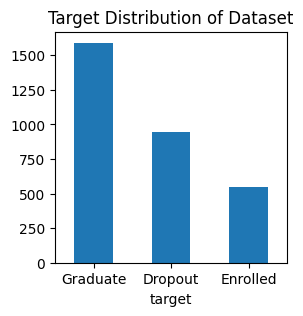

In [84]:
df_2['target'].value_counts()
df_2["target"].value_counts().plot(kind="bar", figsize=(3,3), title="Target Distribution of Dataset")
plt.xticks(rotation=0)
plt.show()

Como existe desbalanceo de clases, usaremos el método de **Balanceo Artificial por vía de Modificación de Función Objetivo** para las muestras que sean de las clases "Dropout" y "Enrolled"

## Separación del dataset en entrenamiento y testing

In [85]:
class_names, y = np.unique(df_2['target'], return_inverse=True)
print(y)
print(class_names)
X = df_2.drop('target', axis=1)

[2 0 2 ... 2 2 0]
['Dropout' 'Enrolled' 'Graduate']


**One Hot Encoding**

In [86]:
one_hot_cols = ['marital_status',
                'daytime_evening_attendance',
                'tuition_fees_up_to_date',
                'educational_special_needs',
                'displaced',
                'scholarship_holder',
                'gender',
                'debtor',
                'international',
                ]

for i in one_hot_cols:
    X[i] = X[i].apply(lambda x: float(x))
    X[i] = X[i].apply(lambda x: int(x))

for i in one_hot_cols:
    dum = pd.get_dummies(X[i], prefix=i)
    X.drop([i], axis=1, inplace=True)
    X = pd.concat([X, dum], axis=1)

**Dividimos el Dataset en entrenamiento y testing**

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_corr = X_train.copy()
X_train_corr['target'] = y_train

**Mapa de correlación de la variable target en base a las diferentes columnas de el Dataset**

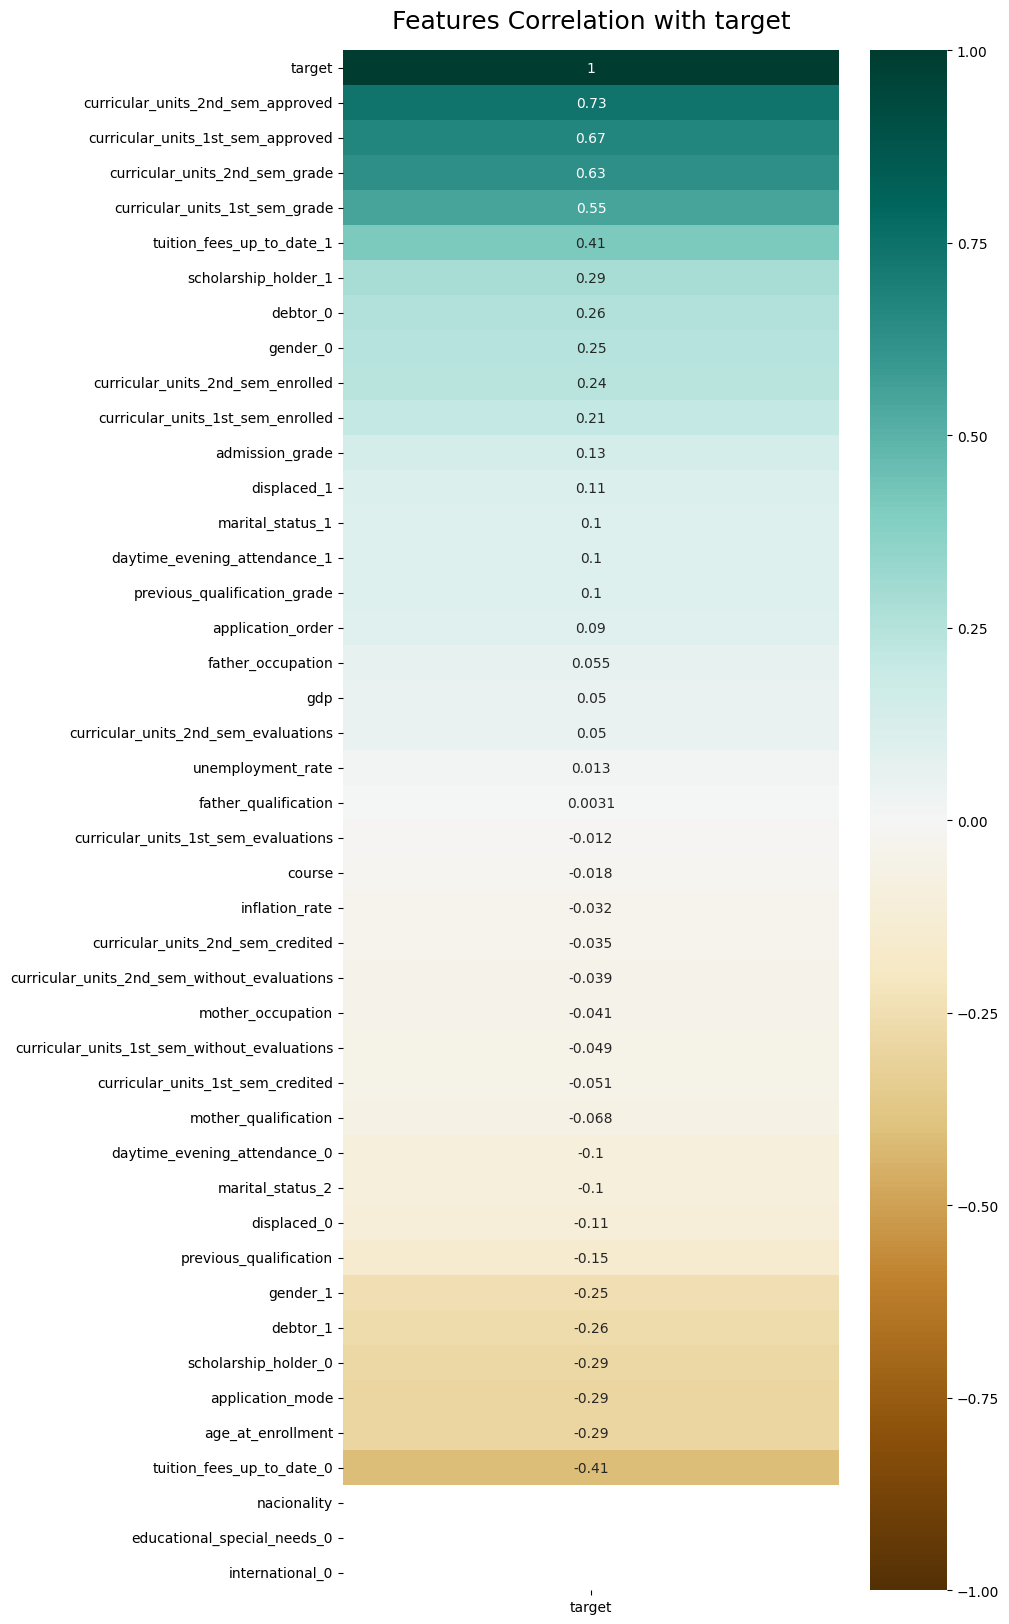

In [88]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(X_train_corr.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlation with target', fontdict={'fontsize':18}, pad=16);

**Seleccionamos las features que deseamos analizar.**

In [89]:
features_list = ['curricular_units_2nd_sem_approved',
                 'curricular_units_1st_sem_approved',
                 'curricular_units_2nd_sem_grade',
                 'curricular_units_1st_sem_grade',
                 'tuition_fees_up_to_date_1',
                 'scholarship_holder_1',
                 'debtor_0',
                 'gender_0',
                 'curricular_units_2nd_sem_enrolled',
                 'curricular_units_1st_sem_enrolled',
                 'tuition_fees_up_to_date_0',
                 'age_at_enrollment',
                 'application_mode',
                 'scholarship_holder_0',
                 'debtor_1',
                 'gender_1']

**Recortamos el entrenamiento y testing a esas features**

In [90]:
X_train_fs = X_train[features_list]
X_test_fs = X_test[features_list]

**Normalizamos de forma estándar los datos, con el fin de no darle más relevancia al número por su tamaño en sí, si no que por su impacto respecto a los otros datos**

In [91]:
scaler = StandardScaler()
scaler.fit(X_train_fs)

X_train_sc = scaler.transform(X_train_fs)
X_test_sc = scaler.transform(X_test_fs)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_fs.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_fs.columns)

**Aplicamos PCA para disminuir la complejidad del modelo**

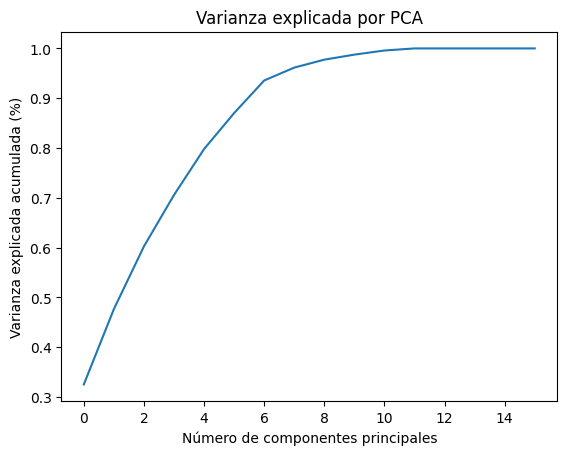

In [92]:
# Ajustar el modelo PCA a los datos de entrenamiento ya escalados
pca = PCA().fit(X_train_sc)

# Crear una figura y graficar la varianza acumulada explicada por los componentes principales
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('Varianza explicada por PCA')
plt.show()

In [93]:
num_pca = 16
pca = PCA(n_components=num_pca, whiten=True).fit(X_train_sc)
X_train_pc = pca.transform(X_train_sc)
X_test_pc = pca.transform(X_test_sc)

**Balanceamos mediante modificación de la Función Objetivo, haciendo variar los pesos**

In [94]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{np.int64(0): np.float64(1.0893015030946065),
 np.int64(1): np.float64(1.837434750186428),
 np.int64(2): np.float64(0.6503035101609923)}

**Notas sobre mejoras implementadas para aumentar la precisión:**

1. **Arquitectura más profunda**: Se aumentó de 3 a 4 capas ocultas con más neuronas (128→64→32→16) para capturar patrones más complejos
2. **Learning rate reducido**: De 0.001 a 0.0005 para un entrenamiento más estable y preciso
3. **Batch size reducido**: De 64 a 32 para mejor generalización
4. **Regularización aumentada**: Weight decay de 0.0001 a 0.0005 para prevenir sobreajuste
5. **Learning rate scheduler**: Reduce automáticamente el learning rate cuando el modelo deja de mejorar
6. **Más épocas**: Aumentado a 200 épocas con early stopping inteligente


## Modelo de predicción

### Bloque de Hiperparámetros

Ajusta estos hiperparámetros manualmente según tus necesidades:

**Configuración de Hiperparámetros**

In [95]:
# ========== HIPERPARÁMETROS - AJUSTAR AQUÍ ==========
HYPERPARAMETERS = {
    'input_size': 16,  # Tamaño de entrada (después de PCA)
    'num_layers': 4,  # Número de capas ocultas (aumentado para mayor capacidad)
    'hidden_sizes': [128, 64, 32, 16],  # Tamaño de cada capa oculta (aumentado)
    'dropout_rates': [0.4, 0.3, 0.2, 0.1],  # Tasa de dropout para cada capa
    'activation': 'relu',  # 'relu', 'tanh', 'sigmoid'
    'learning_rate': 0.0005,  # Learning rate reducido para entrenamiento más estable
    'batch_size': 32,  # Batch size reducido para mejor generalización
    'num_epochs': 200,  # Más épocas para permitir mejor convergencia
    'weight_decay': 0.0005,  # Regularización L2 aumentada para prevenir sobreajuste
    'patience': 25,  # Paciencia aumentada para early stopping
}

print("Hiperparámetros configurados:")
for key, value in HYPERPARAMETERS.items():
    print(f"  {key}: {value}")


Hiperparámetros configurados:
  input_size: 16
  num_layers: 4
  hidden_sizes: [128, 64, 32, 16]
  dropout_rates: [0.4, 0.3, 0.2, 0.1]
  activation: relu
  learning_rate: 0.0005
  batch_size: 32
  num_epochs: 200
  weight_decay: 0.0005
  patience: 25


In [96]:
class StudentDropoutModel(nn.Module):
    """
    Modelo de red neuronal para predecir el abandono de estudiantes.
    Arquitectura: Feedforward con múltiples capas ocultas, dropout y regularización.
    """
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation='relu', num_classes=3):
        super(StudentDropoutModel, self).__init__()
        
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # Seleccionar función de activación
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()
        
        # Crear capas ocultas
        prev_size = input_size
        for hidden_size, dropout_rate in zip(hidden_sizes, dropout_rates):
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Capa de salida
        self.output = nn.Linear(prev_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Pasar por capas ocultas
        for layer, dropout in zip(self.layers, self.dropouts):
            x = layer(x)
            x = self.activation(x)
            x = dropout(x)
        
        # Capa de salida
        x = self.output(x)
        return self.softmax(x)
    
    def predict_class(self, x):
        """Predice la clase más probable"""
        with torch.no_grad():
            probs = self.forward(x)
            return torch.argmax(probs, dim=1)

# Crear instancia del modelo
model = StudentDropoutModel(
    input_size=HYPERPARAMETERS['input_size'],
    hidden_sizes=HYPERPARAMETERS['hidden_sizes'],
    dropout_rates=HYPERPARAMETERS['dropout_rates'],
    activation=HYPERPARAMETERS['activation'],
    num_classes=3
).to(device)

print(f"\nArquitectura del modelo:")
print(model)
print(f"\nNúmero total de parámetros: {sum(p.numel() for p in model.parameters()):,}")


Arquitectura del modelo:
StudentDropoutModel(
  (layers): ModuleList(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.4, inplace=False)
    (1): Dropout(p=0.3, inplace=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (activation): ReLU()
  (output): Linear(in_features=16, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

Número total de parámetros: 13,091


**Dataset y DataLoader para PyTorch**

In [97]:
# Clase Dataset personalizada
class StudentDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Crear datasets
train_dataset = StudentDataset(X_train_pc, y_train)
test_dataset = StudentDataset(X_test_pc, y_test)

# Crear DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=False
)

print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento: 2464
Tamaño del conjunto de prueba: 617


**Entrenamiento del modelo**


In [98]:
# Preparar pesos de clases para manejar desbalance
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in sorted(class_weights.keys())]).to(device)

# Función de pérdida con pesos de clases
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizador con regularización L2 y learning rate scheduler
optimizer = optim.Adam(
    model.parameters(), 
    lr=HYPERPARAMETERS['learning_rate'],
    weight_decay=HYPERPARAMETERS['weight_decay']
)

# Scheduler para reducir learning rate cuando el modelo deja de mejorar
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Listas para almacenar historial
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early stopping
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_state = None
best_epoch = 0

print("Iniciando entrenamiento...\n")

# Barra de progreso para épocas
epoch_pbar = tqdm(range(HYPERPARAMETERS['num_epochs']), desc='Entrenamiento', unit='epoch')

for epoch in epoch_pbar:
    # Entrenamiento
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # Barra de progreso para batches de entrenamiento
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{HYPERPARAMETERS["num_epochs"]} [Train]', 
                      leave=False, unit='batch')
    
    for features, labels in train_pbar:
        features, labels = features.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Actualizar barra de progreso con métricas en tiempo real
        train_acc_batch = 100 * train_correct / train_total
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{train_acc_batch:.2f}%'
        })
    
    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validación
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Barra de progreso para batches de validación
    val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{HYPERPARAMETERS["num_epochs"]} [Val]', 
                    leave=False, unit='batch')
    
    with torch.no_grad():
        for features, labels in val_pbar:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Actualizar barra de progreso
            val_acc_batch = 100 * val_correct / val_total
            val_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{val_acc_batch:.2f}%'
            })
    
    val_loss /= len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Actualizar learning rate scheduler
    scheduler.step(val_loss)
    
    # Actualizar barra de progreso principal
    epoch_pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Train Acc': f'{train_acc:.2f}%',
        'Val Loss': f'{val_loss:.4f}',
        'Val Acc': f'{val_acc:.2f}%',
        'Best Val Acc': f'{best_val_acc:.2f}%',
        'Patience': f'{patience_counter}/{HYPERPARAMETERS["patience"]}'
    })
    
    # Early stopping con mejor modelo basado en validación
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1
        epoch_pbar.write(f'✓ Mejora en epoch {epoch+1}: Val Loss mejoró de {best_val_loss + improvement:.4f} a {best_val_loss:.4f} (Val Acc: {val_acc:.2f}%)')
    else:
        patience_counter += 1
        if patience_counter >= HYPERPARAMETERS['patience']:
            epoch_pbar.write(f'\n⚠ Early stopping activado en epoch {epoch+1}')
            epoch_pbar.write(f'   Mejor modelo encontrado en epoch {best_epoch}')
            epoch_pbar.write(f'   Mejor Val Loss: {best_val_loss:.4f}')
            epoch_pbar.write(f'   Mejor Val Acc: {best_val_acc:.2f}%')
            epoch_pbar.write(f'   Razón: No hubo mejora en Val Loss por {HYPERPARAMETERS["patience"]} épocas consecutivas')
            epoch_pbar.write(f'   El modelo se detuvo para prevenir sobreajuste (overfitting)')
            model.load_state_dict(best_model_state)
            break

epoch_pbar.close()
print("\n" + "="*60)
print("ENTRENAMIENTO COMPLETADO")
print("="*60)
print(f"Mejor modelo guardado de epoch {best_epoch}")
print(f"Mejor Val Loss: {best_val_loss:.4f}")
print(f"Mejor Val Acc: {best_val_acc:.2f}%")
print(f"Total de épocas entrenadas: {len(train_losses)}")
if patience_counter >= HYPERPARAMETERS['patience']:
    print(f"\n📊 EXPLICACIÓN DEL EARLY STOPPING:")
    print(f"   El entrenamiento se detuvo en epoch {len(train_losses)} porque:")
    print(f"   - La pérdida de validación no mejoró por {HYPERPARAMETERS['patience']} épocas consecutivas")
    print(f"   - Esto indica que el modelo ya no está aprendiendo patrones útiles")
    print(f"   - Continuar entrenando podría causar sobreajuste (overfitting)")
    print(f"   - Se restauró el mejor modelo encontrado (epoch {best_epoch})")


Iniciando entrenamiento...



Entrenamiento:   0%|          | 1/200 [00:00<02:36,  1.27epoch/s, Train Loss=1.0918, Train Acc=25.65%, Val Loss=1.0665, Val Acc=59.00%, Best Val Acc=0.00%, Patience=0/25]

✓ Mejora en epoch 1: Val Loss mejoró de inf a 1.0665 (Val Acc: 59.00%)


Entrenamiento:   1%|          | 2/200 [00:01<02:20,  1.41epoch/s, Train Loss=1.0216, Train Acc=62.30%, Val Loss=0.9315, Val Acc=76.18%, Best Val Acc=59.00%, Patience=0/25]

✓ Mejora en epoch 2: Val Loss mejoró de 1.0665 a 0.9315 (Val Acc: 76.18%)


Entrenamiento:   2%|▏         | 3/200 [00:02<02:13,  1.48epoch/s, Train Loss=0.9289, Train Acc=73.50%, Val Loss=0.8700, Val Acc=76.99%, Best Val Acc=76.18%, Patience=0/25]

✓ Mejora en epoch 3: Val Loss mejoró de 0.9315 a 0.8700 (Val Acc: 76.99%)


Entrenamiento:   2%|▏         | 4/200 [00:02<02:10,  1.50epoch/s, Train Loss=0.9002, Train Acc=73.90%, Val Loss=0.8501, Val Acc=78.12%, Best Val Acc=76.99%, Patience=0/25]

✓ Mejora en epoch 4: Val Loss mejoró de 0.8700 a 0.8501 (Val Acc: 78.12%)


Entrenamiento:   2%|▎         | 5/200 [00:03<02:09,  1.50epoch/s, Train Loss=0.8850, Train Acc=73.90%, Val Loss=0.8394, Val Acc=77.47%, Best Val Acc=78.12%, Patience=0/25]

✓ Mejora en epoch 5: Val Loss mejoró de 0.8501 a 0.8394 (Val Acc: 77.47%)


Entrenamiento:   3%|▎         | 6/200 [00:04<02:13,  1.45epoch/s, Train Loss=0.8725, Train Acc=71.88%, Val Loss=0.8380, Val Acc=76.66%, Best Val Acc=77.47%, Patience=0/25]

✓ Mejora en epoch 6: Val Loss mejoró de 0.8394 a 0.8380 (Val Acc: 76.66%)


Entrenamiento:   4%|▎         | 7/200 [00:04<02:14,  1.43epoch/s, Train Loss=0.8659, Train Acc=74.11%, Val Loss=0.8295, Val Acc=77.63%, Best Val Acc=76.66%, Patience=0/25]

✓ Mejora en epoch 7: Val Loss mejoró de 0.8380 a 0.8295 (Val Acc: 77.63%)


Entrenamiento:   4%|▍         | 8/200 [00:05<02:37,  1.22epoch/s, Train Loss=0.8534, Train Acc=74.47%, Val Loss=0.8201, Val Acc=76.18%, Best Val Acc=77.63%, Patience=0/25]

✓ Mejora en epoch 8: Val Loss mejoró de 0.8295 a 0.8201 (Val Acc: 76.18%)


Entrenamiento:   4%|▍         | 9/200 [00:06<02:37,  1.21epoch/s, Train Loss=0.8467, Train Acc=74.88%, Val Loss=0.8186, Val Acc=76.50%, Best Val Acc=76.18%, Patience=0/25]

✓ Mejora en epoch 9: Val Loss mejoró de 0.8201 a 0.8186 (Val Acc: 76.50%)


Entrenamiento:   6%|▋         | 13/200 [00:10<02:27,  1.26epoch/s, Train Loss=0.8508, Train Acc=73.94%, Val Loss=0.8144, Val Acc=78.44%, Best Val Acc=76.50%, Patience=3/25]

✓ Mejora en epoch 13: Val Loss mejoró de 0.8186 a 0.8144 (Val Acc: 78.44%)


Entrenamiento:   7%|▋         | 14/200 [00:10<02:26,  1.27epoch/s, Train Loss=0.8352, Train Acc=76.42%, Val Loss=0.8143, Val Acc=77.15%, Best Val Acc=78.44%, Patience=0/25]

✓ Mejora en epoch 14: Val Loss mejoró de 0.8144 a 0.8143 (Val Acc: 77.15%)


Entrenamiento:   8%|▊         | 16/200 [00:13<03:04,  1.00s/epoch, Train Loss=0.8349, Train Acc=74.43%, Val Loss=0.8119, Val Acc=76.50%, Best Val Acc=77.15%, Patience=1/25]

✓ Mejora en epoch 16: Val Loss mejoró de 0.8143 a 0.8119 (Val Acc: 76.50%)


Entrenamiento:  11%|█         | 22/200 [00:19<03:07,  1.06s/epoch, Train Loss=0.8260, Train Acc=74.96%, Val Loss=0.8118, Val Acc=76.66%, Best Val Acc=76.50%, Patience=5/25]

✓ Mejora en epoch 22: Val Loss mejoró de 0.8119 a 0.8118 (Val Acc: 76.66%)


Entrenamiento:  12%|█▏        | 24/200 [00:21<03:25,  1.17s/epoch, Train Loss=0.8157, Train Acc=76.42%, Val Loss=0.8087, Val Acc=76.82%, Best Val Acc=76.66%, Patience=1/25]

✓ Mejora en epoch 24: Val Loss mejoró de 0.8118 a 0.8087 (Val Acc: 76.82%)


Entrenamiento:  14%|█▍        | 29/200 [00:27<03:01,  1.06s/epoch, Train Loss=0.8193, Train Acc=76.66%, Val Loss=0.8081, Val Acc=76.66%, Best Val Acc=76.82%, Patience=4/25]

✓ Mejora en epoch 29: Val Loss mejoró de 0.8087 a 0.8081 (Val Acc: 76.66%)


Entrenamiento:  18%|█▊        | 35/200 [00:33<02:51,  1.04s/epoch, Train Loss=0.8182, Train Acc=76.26%, Val Loss=0.8052, Val Acc=77.47%, Best Val Acc=76.66%, Patience=5/25]

✓ Mejora en epoch 35: Val Loss mejoró de 0.8081 a 0.8052 (Val Acc: 77.47%)


Entrenamiento:  20%|█▉        | 39/200 [00:38<03:08,  1.17s/epoch, Train Loss=0.8103, Train Acc=77.03%, Val Loss=0.8005, Val Acc=77.47%, Best Val Acc=77.47%, Patience=3/25]

✓ Mejora en epoch 39: Val Loss mejoró de 0.8052 a 0.8005 (Val Acc: 77.47%)


Entrenamiento:  26%|██▌       | 51/200 [00:52<02:34,  1.04s/epoch, Train Loss=0.8083, Train Acc=76.95%, Val Loss=0.8002, Val Acc=76.99%, Best Val Acc=77.47%, Patience=11/25]

✓ Mejora en epoch 51: Val Loss mejoró de 0.8005 a 0.8002 (Val Acc: 76.99%)


Entrenamiento:  26%|██▌       | 52/200 [00:53<02:38,  1.07s/epoch, Train Loss=0.8044, Train Acc=76.34%, Val Loss=0.8000, Val Acc=77.63%, Best Val Acc=76.99%, Patience=0/25] 

✓ Mejora en epoch 52: Val Loss mejoró de 0.8002 a 0.8000 (Val Acc: 77.63%)


Entrenamiento:  26%|██▋       | 53/200 [00:54<02:36,  1.07s/epoch, Train Loss=0.8025, Train Acc=76.58%, Val Loss=0.7979, Val Acc=77.80%, Best Val Acc=77.63%, Patience=0/25]

✓ Mejora en epoch 53: Val Loss mejoró de 0.8000 a 0.7979 (Val Acc: 77.80%)


Entrenamiento:  28%|██▊       | 57/200 [00:58<02:34,  1.08s/epoch, Train Loss=0.8031, Train Acc=77.11%, Val Loss=0.7978, Val Acc=77.47%, Best Val Acc=77.80%, Patience=3/25]

✓ Mejora en epoch 57: Val Loss mejoró de 0.7979 a 0.7978 (Val Acc: 77.47%)


Entrenamiento:  40%|████      | 81/200 [01:22<02:00,  1.01s/epoch, Train Loss=0.7992, Train Acc=76.95%, Val Loss=0.8022, Val Acc=76.82%, Best Val Acc=77.47%, Patience=24/25]


⚠ Early stopping activado en epoch 82
   Mejor modelo encontrado en epoch 57
   Mejor Val Loss: 0.7978
   Mejor Val Acc: 77.47%
   Razón: No hubo mejora en Val Loss por 25 épocas consecutivas
   El modelo se detuvo para prevenir sobreajuste (overfitting)

ENTRENAMIENTO COMPLETADO
Mejor modelo guardado de epoch 57
Mejor Val Loss: 0.7978
Mejor Val Acc: 77.47%
Total de épocas entrenadas: 82

📊 EXPLICACIÓN DEL EARLY STOPPING:
   El entrenamiento se detuvo en epoch 82 porque:
   - La pérdida de validación no mejoró por 25 épocas consecutivas
   - Esto indica que el modelo ya no está aprendiendo patrones útiles
   - Continuar entrenando podría causar sobreajuste (overfitting)
   - Se restauró el mejor modelo encontrado (epoch 57)


**Gráfico de pérdida por épocas**


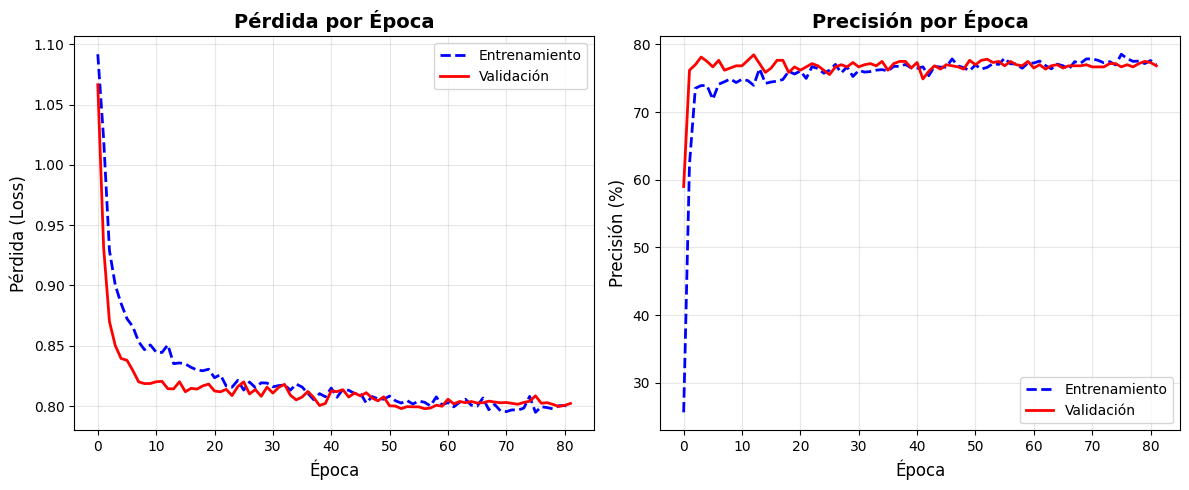

Mejor pérdida de validación: 0.7978
Mejor precisión de validación: 78.44%


In [99]:
# Graficar pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b--', label='Entrenamiento', linewidth=2)
plt.plot(val_losses, 'r-', label='Validación', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida (Loss)', fontsize=12)
plt.title('Pérdida por Época', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b--', label='Entrenamiento', linewidth=2)
plt.plot(val_accuracies, 'r-', label='Validación', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.title('Precisión por Época', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mejor pérdida de validación: {min(val_losses):.4f}")
print(f"Mejor precisión de validación: {max(val_accuracies):.2f}%")


**Evaluación final y métricas**


In [100]:
# Evaluación en el conjunto de prueba
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convertir a arrays de numpy
y_pred = np.array(all_predictions)
y_true = np.array(all_labels)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("=" * 60)
print("RESULTADOS FINALES DEL MODELO")
print("=" * 60)
print(f"\nPrecisión (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precisión (Precision - Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")
print("\n" + "=" * 60)
print("\nReporte de Clasificación Detallado:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


RESULTADOS FINALES DEL MODELO

Precisión (Accuracy): 0.7682 (76.82%)
Precisión (Precision - Weighted): 0.8068
Recall (Weighted): 0.7682
F1-Score (Weighted): 0.7802


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

     Dropout       0.91      0.71      0.79       190
    Enrolled       0.42      0.64      0.51        99
    Graduate       0.87      0.84      0.85       328

    accuracy                           0.77       617
   macro avg       0.73      0.73      0.72       617
weighted avg       0.81      0.77      0.78       617



**Matriz de Confusión**


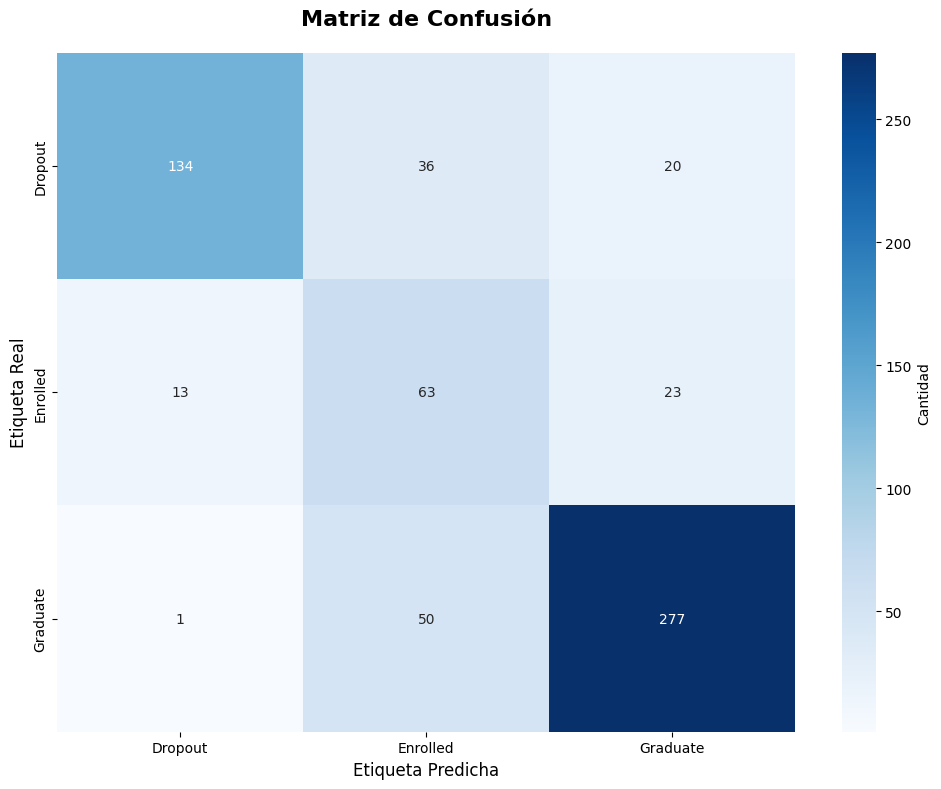


Matriz de Confusión:
               Dropout        Enrolled       Graduate       
Dropout                    134             36             20
Enrolled                    13             63             23
Graduate                     1             50            277

Métricas por Clase:

Dropout:
  Precision: 0.9054
  Recall: 0.7053
  F1-Score: 0.7929
  Soporte: 190

Enrolled:
  Precision: 0.4228
  Recall: 0.6364
  F1-Score: 0.5081
  Soporte: 99

Graduate:
  Precision: 0.8656
  Recall: 0.8445
  F1-Score: 0.8549
  Soporte: 328


In [101]:
# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Mostrar matriz de confusión en formato numérico
print("\nMatriz de Confusión:")
print("=" * 60)
print(f"{'':15}", end="")
for name in class_names:
    print(f"{name:15}", end="")
print()
for i, name in enumerate(class_names):
    print(f"{name:15}", end="")
    for j in range(len(class_names)):
        print(f"{cm[i, j]:15}", end="")
    print()
print("=" * 60)

# Calcular métricas por clase
print("\nMétricas por Clase:")
print("=" * 60)
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Precision: {precision_class:.4f}")
    print(f"  Recall: {recall_class:.4f}")
    print(f"  F1-Score: {f1_class:.4f}")
    print(f"  Soporte: {cm[i, :].sum()}")


**Ejemplo de aplicación del Modelo**


In [102]:
def predict_student(student_data, model, scaler, pca, class_names, device):
    """
    Predice la clase de un estudiante.
    
    Args:
        student_data: dict con los datos del estudiante, las mismas columnas que X_train_fs
        model: modelo entrenado de PyTorch
        scaler: objeto StandardScaler usado para normalizar los datos
        pca: objeto PCA usado para reducir dimensiones
        class_names: lista de nombres de clases ['Dropout', 'Enrolled', 'Graduate']
        device: dispositivo (CPU o GPU)
    """
    model.eval()
    
    # Convertir el dict a DataFrame
    df = pd.DataFrame([student_data])
    
    # Asegurarse de tener todas las columnas de entrenamiento
    missing_cols = set(X_train_fs.columns) - set(df.columns)
    for col in missing_cols:
        df[col] = 0  # rellenar con 0 si falta alguna columna
    
    # Ordenar columnas igual que X_train_fs
    df = df[X_train_fs.columns]
    
    # Escalar
    df_scaled = scaler.transform(df)
    
    # PCA
    df_pc = pca.transform(df_scaled)
    
    # Convertir a tensor y predecir
    with torch.no_grad():
        df_tensor = torch.FloatTensor(df_pc).to(device)
        probs = model(df_tensor)
        pred_class_idx = torch.argmax(probs, dim=1).item()
        probabilities = probs[0].cpu().numpy()
    
    return class_names[pred_class_idx], probabilities

# Ejemplo de uso
student = {
    'curricular_units_2nd_sem_approved': 5,
    'curricular_units_1st_sem_approved': 6,
    'curricular_units_2nd_sem_grade': 12.5,
    'curricular_units_1st_sem_grade': 13.0,
    'tuition_fees_up_to_date_1': 1,
    'scholarship_holder_1': 0,
    'debtor_0': 1,
    'gender_0': 1,
    'curricular_units_2nd_sem_enrolled': 6,
    'curricular_units_1st_sem_enrolled': 6,
    'tuition_fees_up_to_date_0': 0,
    'age_at_enrollment': 20,
    'application_mode': 1,
    'scholarship_holder_0': 1,
    'debtor_1': 0,
    'gender_1': 0
}

resultado, probabilidades = predict_student(student, model, scaler, pca, class_names, device)
print(f"Predicción del estudiante: {resultado}")
print("\nProbabilidades por clase:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {probabilidades[i]:.4f} ({probabilidades[i]*100:.2f}%)")


Predicción del estudiante: Graduate

Probabilidades por clase:
  Dropout: 0.0000 (0.00%)
  Enrolled: 0.0132 (1.32%)
  Graduate: 0.9868 (98.68%)


c:\Users\Bruno\Desktop\INF395 - IRN\proyecto_redes_neuronales\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


**Pequeño ejemplo de aplicacion del Modelo**